In [1]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC  
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn import tree

from sklearn import metrics
from sklearn.model_selection import train_test_split

from sktime.classification.shapelet_based import MrSEQLClassifier
from sktime.datasets import load_arrow_head, load_basic_motions

from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.transformations.panel.rocket import Rocket
from sklearn.linear_model import RidgeClassifierCV

from sktime.datasets import load_arrow_head 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
import warnings

warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", 100)

In [2]:
# Opening up file containing GWAS data and reading in

file = open("GWAS_Add.raw", "r")
lines = file.readlines()
len(lines)

90

In [3]:
# Loading GWAS data into DF in the correct format

columns = lines[0].strip("\n").split(" ")
columns = [n.split("_", 1)[0] for n in columns]
df = pd.DataFrame(columns=columns)
data = []
for line in lines[1:]:
    newRow = line.strip("\n").split(" ")
    for position in range(0, len(newRow)):
        if newRow[position] == "0":
            newRow[position] = "2"
        elif newRow[position] == "2":
            newRow[position] = "0"
        
    data.append(newRow)

df = pd.DataFrame(data, columns=columns)

In [4]:
# Sanity check to see if control SNPs have been encoded correctly control

df1 = df[["rs2222162","PHENOTYPE"]]
df1[df1["PHENOTYPE"] == "1"].value_counts()

rs2222162  PHENOTYPE
1          1            22
0          1            17
2          1             6
dtype: int64

In [5]:
# Sanity check to see if cases SNPs have been encoded correctly case

df1 = df[["rs2222162","PHENOTYPE"]]
df1[df1["PHENOTYPE"] == "0"].value_counts()

rs2222162  PHENOTYPE
2          0            22
1          0            19
0          0             3
dtype: int64

In [6]:
df

FID IID PAT MAT SEX PHENOTYPE rs6681049 rs4074137 rs7540009 rs1891905  \
0   HCB181   1   2   2   1         1         2         2         2         1   
1   HCB182   1   2   2   1         1         2         1         2         1   
2   HCB183   1   2   2   1         0         2         1         2         1   
3   HCB184   1   2   2   1         1         2         1         2         0   
4   HCB185   1   2   2   1         1         2         1         2         2   
5   HCB186   1   2   2   1         1         2         2         2         0   
6   HCB187   1   2   2   1         1         2         2         2         1   
7   HCB188   1   2   2   1         1         2         1         2         0   
8   HCB189   1   2   2   1         1         2         2         2         2   
9   HCB190   1   2   2   1         1         2         2         2         2   
10  HCB191   1   2   2   1         0         1         2         2         1   
11  HCB192   1   2   2   1         1         2         2         2         0   
12  HCB193   1   2   2   1         1         1         2         2         2   
13  HCB194   1   2   2   1         1         2         2         2         1   
14  HCB195   1   2   2   1         1         2         2         2         2   
15  HCB196   1   2   2   1         1         1         2         2         2   
16  HCB197   1   2   2   1         1         1         2         2         2   
17  HCB198   1   2   2   1         1         1         1         2         1   
18  HCB199   1   2   2   1         1         1         2         2         0   
19  HCB200   1   2   2   1         1         0         2         2         0   
20  HCB201   1   2   2   1         0         1         2         2         2   
21  HCB202   1   2   2   1         1         0         2         2         0   
22  HCB203   1   2   2   1         1         2         2         2         2   
23  HCB204   1   2   2   1         1         1         2         2         1   
24  HCB205   1   2   2   1         1         1         2         2         2   
25  HCB206   1   2   2   1         1         2         2         2         1   
26  HCB207   1   2   2   1         0         1         2         2         2   
27  HCB208   1   2   2   1         1         2         2         2         0   
28  HCB209   1   2   2   1         1         1         1         2         2   
29  HCB210   1   2   2   1         0         2         2         2         1   
30  HCB211   1   2   2   1         0         2         2         2         1   
31  HCB212   1   2   2   1         1         1         2         2         0   
32  HCB213   1   2   2   1         1         1         2         2         2   
33  HCB214   1   2   2   1         0         2         1         2         1   
34  HCB215   1   2   2   1         0         2         2         2         2   
35  HCB216   1   2   2   1         1         0         2         2         2   
36  HCB217   1   2   2   1         1         2         2         2         2   
37  HCB218   1   2   2   1         1         2         2         2         2   
38  HCB219   1   2   2   1         0         1         2         2         1   
39  HCB220   1   2   2   1         1         2         1         2         0   
40  HCB221   1   2   2   1         0         2         2         2         2   
41  HCB222   1   2   2   1         1         2         2         2         2   
42  HCB223   1   2   2   1         1         1         2         2         1   
43  HCB224   1   2   2   1         0         2         2         2         0   
44  HCB225   1   2   2   1         1         2         2         2         1   
45  JPT226   1   2   2   1         1         1         2         2         1   
46  JPT227   1   2   2   1         0         2         2         2         0   
47  JPT228   1   2   2   1         1         2         2         2         2   
48  JPT229   1   2   2   1         0         2         2         2         1   
49  JPT

In [7]:
# Only selecting 100 SNPs located on chromosome 2 

dfAlleles = df.loc[:, "rs11684739":"rs2521953"]
dfInfo = df.loc[:, :"PHENOTYPE"]
df = dfInfo.join(dfAlleles)
len(df.columns)

106

In [8]:
# Fixing Phenotype values

df["PHENOTYPE"] = df["PHENOTYPE"].replace("0","case")
df["PHENOTYPE"] = df["PHENOTYPE"].replace("1","control")

In [9]:
# Removing ID columns and 

phenotype = df.pop("PHENOTYPE")
dfTest = df.drop(columns=["FID","IID","PAT","MAT","SEX"])

In [10]:
# Replacing missing SNP entries and replacing with most frequent value for that SNP of other entries

imp = SimpleImputer(missing_values="NA", strategy="most_frequent")
idf = pd.DataFrame(imp.fit_transform(dfTest))
idf.columns = dfTest.columns

In [11]:
# Converting columns to be numberical

idf = idf.apply(pd.to_numeric)

In [12]:
# Getting index of SNP of interest

idfT = idf.T

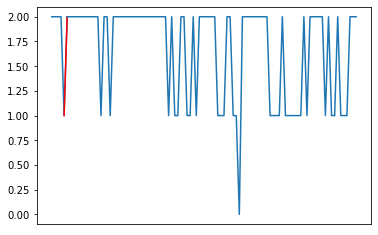

In [24]:
# Visualising entry 0 - control

position = idfT[0].index.get_loc("rs2222162")
plt.xticks([])
plt.plot(idfT[0][0:position+1], color="tab:blue")
plt.plot(idfT[0][position-1:position+1], color="red")
plt.plot(idfT[0][position:],color="tab:blue")
phenotype[0], idfT[0][position]

('control', 0)

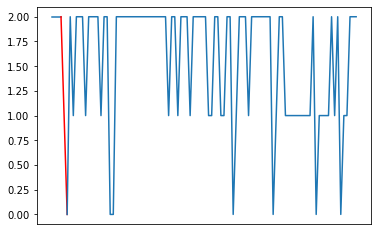

In [162]:
# Visualising entry 8 - control

position = idfT[8].index.get_loc("rs2222162")
plt.xticks([])
plt.plot(idfT[8][0:position-1], color="tab:blue")
plt.plot(idfT[8][position-2:position+1], color="red")
plt.plot(idfT[8][position:],color="tab:blue")
phenotype[8], idfT[8][position]

('case', 2)

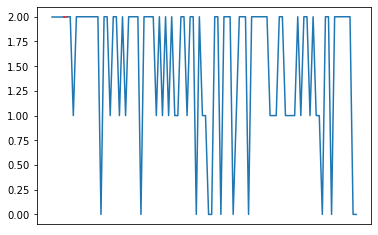

In [163]:
# Visualising entry 2 - case

position = idfT[2].index.get_loc("rs2222162")
plt.xticks([])
plt.plot(idfT[2][0:position], color="tab:blue")
plt.plot(idfT[2][position-1:position+1], color="red")
plt.plot(idfT[2][position:],color="tab:blue")
phenotype[2], idfT[2][position]

('case', 1)

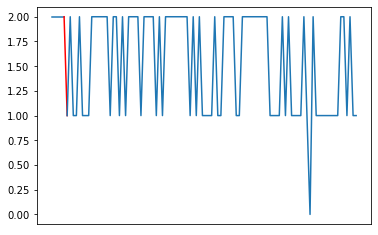

In [164]:
# Visualising entry 88 - case

position = idfT[88].index.get_loc("rs2222162")
plt.xticks([])
plt.plot(idfT[88][0:position], color="tab:blue")
plt.plot(idfT[88][position-1:position+1], color="red")
plt.plot(idfT[88][position:],color="tab:blue")
phenotype[88], idfT[88][position]

In [26]:
# Classifying GWAS data using random forest and printing results
testingResults = []
for n in range(0,10):
    
    xTrain, xTtest, yTrain, yTest = train_test_split(idf, phenotype, train_size=0.7)
    rfc = RandomForestClassifier()
    rfc.fit(xTrain, yTrain)
    yPredicted = rfc.predict(xTrain)
    yTestPredicted = rfc.predict(xTtest)
    testingResults.append(accuracy_score(yTest, yTestPredicted))
    
print("Testing accuracy score: "+ str(sum(testingResults)/len(testingResults)))

print(confusion_matrix(yTest, yTestPredicted))
print(classification_report(yTest, yTestPredicted))

Testing accuracy score: 0.5555555555555556
[[ 6  6]
 [11  4]]
              precision    recall  f1-score   support

        case       0.35      0.50      0.41        12
     control       0.40      0.27      0.32        15

    accuracy                           0.37        27
   macro avg       0.38      0.38      0.37        27
weighted avg       0.38      0.37      0.36        27



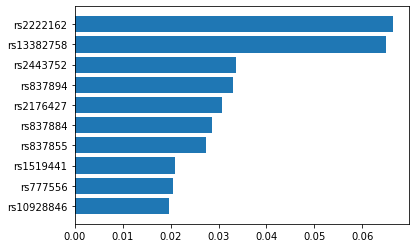

In [27]:
# Plotting features that random forest classifier found important

rf =  pd.DataFrame({"featrue": idf.columns, "importance":rfc.feature_importances_})
sorted_idx = rfc.feature_importances_.argsort()
plt.barh(idf.columns[sorted_idx[-10:]], rfc.feature_importances_[sorted_idx[-10:]])

In [167]:
# Converting df columns into 2d numpy array time series

idf = idf.apply(pd.to_numeric)
idfSeries = from_2d_array_to_nested(idf)

In [168]:
# Classifying GWAS data using ROCKET and printing results

testingResults = []

for n in range(0,10):
    xTrain, xTest, yTrain, yTest = train_test_split(idfSeries, phenotype, train_size=0.7)

    # Extracting values from training split
    yTrain = yTrain.values
    yTest = yTest.values
    xTrain = xTrain.reset_index()
    xTrain = xTrain.drop(columns=["index"])
    xTest = xTest.reset_index()
    xTest = xTest.drop(columns=["index"])
    
    # Running rocket kernal transformation on training data
    rocket = Rocket()
    rocket.fit(xTrain)
    xTrainTransform = rocket.transform(xTrain)
    classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
    classifier.fit(xTrainTransform, yTrain)
    xTestTransform = rocket.transform(xTest)
    yTestPredicted = classifier.predict(xTestTransform)
    testingResults.append(accuracy_score(yTest, yTestPredicted))
    
print("Testing accuracy score: "+ str(sum(testingResults)/len(testingResults)))

print(confusion_matrix(yTest, yTestPredicted))
print(classification_report(yTest, yTestPredicted))

Testing accuracy score: 0.5037037037037038
[[5 6]
 [8 8]]
              precision    recall  f1-score   support

        case       0.38      0.45      0.42        11
     control       0.57      0.50      0.53        16

    accuracy                           0.48        27
   macro avg       0.48      0.48      0.47        27
weighted avg       0.50      0.48      0.49        27



In [169]:
# Classifying GWAS data using MrSEQL and printing results

testingResults = []

for n in range(0,10):
    xTrain, xTest, yTrain, yTest = train_test_split(idfSeries, phenotype, train_size=0.7)

    # Extracting values from training split
    yTrain = yTrain.values
    yTest = yTest.values
    xTrain = xTrain.reset_index()
    xTrain = xTrain.drop(columns=["index"])
    xTest = xTest.reset_index()
    xTest = xTest.drop(columns=["index"])
    
    # Running rocket kernal transformation on training data
    ms = MrSEQLClassifier(seql_mode="clf")
    ms.fit(xTrain, yTrain)
    yTestPredicted = ms.predict(xTest)
    testingResults.append(accuracy_score(yTest, yTestPredicted))
    
print("Testing accuracy score: "+ str(sum(testingResults)/len(testingResults)))
print(confusion_matrix(yTest, yTestPredicted))
print(classification_report(yTest, yTestPredicted))

Testing accuracy score: 0.5407407407407407
[[ 6  5]
 [ 6 10]]
              precision    recall  f1-score   support

        case       0.50      0.55      0.52        11
     control       0.67      0.62      0.65        16

    accuracy                           0.59        27
   macro avg       0.58      0.59      0.58        27
weighted avg       0.60      0.59      0.59        27



In [170]:
# Duplicating SNP of interest to emulate area with associated SNPs

len(idf.columns)
for n in range(0,9):
    idf.insert(idf.columns.get_loc("rs2222162"), f"rs222216_{n}", dfTest["rs2222162"])

In [171]:
len(idf.columns)

109

In [172]:
# Classifying GWAS data using random forest with area of associated SNPs

testingResults = []
for n in range(0,10):
    
    xTrain, xTtest, yTrain, yTest = train_test_split(idf, phenotype, train_size=0.7)
    rfc = RandomForestClassifier()
    rfc.fit(xTrain, yTrain)
    yPredicted = rfc.predict(xTrain)
    trainingResults.append(accuracy_score(yTrain, yPredicted))
    yTestPredicted = rfc.predict(xTtest)
    testingResults.append(accuracy_score(yTest, yTestPredicted))
    
print("Testing accuracy score: "+ str(sum(testingResults)/len(testingResults)))

print(confusion_matrix(yTest, yTestPredicted))
print(classification_report(yTest, yTestPredicted))

Testing accuracy score: 0.6666666666666667
[[10  7]
 [ 4  6]]
              precision    recall  f1-score   support

        case       0.71      0.59      0.65        17
     control       0.46      0.60      0.52        10

    accuracy                           0.59        27
   macro avg       0.59      0.59      0.58        27
weighted avg       0.62      0.59      0.60        27



<BarContainer object of 10 artists>

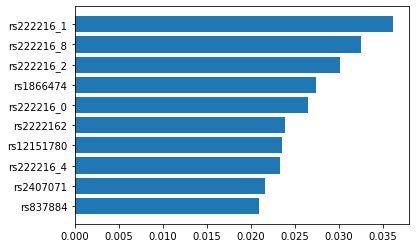

In [173]:
# Plotting features that random forest classifier found important

rf =  pd.DataFrame({"featrue": idf.columns, "importance":rfc.feature_importances_})
sorted_idx = rfc.feature_importances_.argsort()
plt.barh(idf.columns[sorted_idx[-10:]], rfc.feature_importances_[sorted_idx[-10:]])

In [174]:
# Converting df columns into 2d numpy array time series

idf = idf.apply(pd.to_numeric)
idfSeries = from_2d_array_to_nested(idf)

In [175]:
# Classifying GWAS data using ROCKET with area of associated SNPs

testingResults = []
for n in range(0,10):
    xTrain, xTest, yTrain, yTest = train_test_split(idfSeries, phenotype, train_size=0.7)

    # Extracting values from training split
    yTrain = yTrain.values
    yTest = yTest.values
    xTrain = xTrain.reset_index()
    xTrain = xTrain.drop(columns=["index"])
    xTest = xTest.reset_index()
    xTest = xTest.drop(columns=["index"])
    
    # Running rocket kernal transformation on training data
    rocket = Rocket()
    rocket.fit(xTrain)
    xTrainTransform = rocket.transform(xTrain)
    classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
    classifier.fit(xTrainTransform, yTrain)
    xTestTransform = rocket.transform(xTest)
    yTestPredicted = classifier.predict(xTestTransform)
    testingResults.append(accuracy_score(yTest, yTestPredicted))
    
print("Testing accuracy score: "+ str(sum(testingResults)/len(testingResults)))

print(confusion_matrix(yTest, yTestPredicted))
print(classification_report(yTest, yTestPredicted))

Testing accuracy score: 0.6222222222222222
[[ 6  7]
 [ 3 11]]
              precision    recall  f1-score   support

        case       0.67      0.46      0.55        13
     control       0.61      0.79      0.69        14

    accuracy                           0.63        27
   macro avg       0.64      0.62      0.62        27
weighted avg       0.64      0.63      0.62        27



In [176]:
# Classifying GWAS data using MrSEQL with area of associated SNPs

testingResults = []

for n in range(0,10):
    xTrain, xTest, yTrain, yTest = train_test_split(idfSeries, phenotype, train_size=0.7)

    # Extracting values from training split
    yTrain = yTrain.values
    yTest = yTest.values
    xTrain = xTrain.reset_index()
    xTrain = xTrain.drop(columns=["index"])
    xTest = xTest.reset_index()
    xTest = xTest.drop(columns=["index"])
    
    # Running rocket kernal transformation on training data
    ms = MrSEQLClassifier(seql_mode="clf")
    ms.fit(xTrain, yTrain)
    yTestPredicted = ms.predict(xTest)
    testingResults.append(accuracy_score(yTest, yTestPredicted))
    
print("Testing accuracy score: "+ str(sum(testingResults)/len(testingResults)))
print(confusion_matrix(yTest, yTestPredicted))
print(classification_report(yTest, yTestPredicted))

Testing accuracy score: 0.6407407407407408
[[10  4]
 [ 1 12]]
              precision    recall  f1-score   support

        case       0.91      0.71      0.80        14
     control       0.75      0.92      0.83        13

    accuracy                           0.81        27
   macro avg       0.83      0.82      0.81        27
weighted avg       0.83      0.81      0.81        27

